In [1]:
# THIS MODEL IS BUILT TO OVERFIT

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt

import os
import glob

In [11]:
def see_images(imgs, labels):
    # plt.figure(figsize = (10,5*len(imgs)))
    # if type(imgs) != 'list':
    #   imgs = imgs.detach().numpy()
    # print(type(imgs))
    for i, img in enumerate(imgs):
      img = ((img / img.max()) * 255).astype(np.uint8)
    
      plt.subplot(int("1" + str(len(imgs) + 1) + str(i+1)))
      plt.imshow(img)
      plt.title(labels[i])
    plt.show()

def unpack_pickle(path_with_file_name):
    x = y = None
    with open(path_with_file_name, 'rb') as pickle_file:
        data = pickle.load(pickle_file)
        x = data[0]
        y = data[1]
        # Need to take out empty array in x set, since there is a left over array on the left side of the list for each image (see comment at top of file)
        x = [temp[1] for temp in x]
    return x, y

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
os.chdir('/content/drive/Shareddrives/ECE_792_Advanced_Topics_in_ML/compressed_images')


Train Image


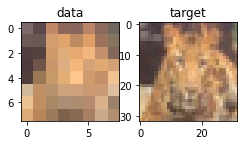

X Train Image Shape: (8, 8, 3)
Y Train Image Shape: (32, 32, 3)
Valid Image


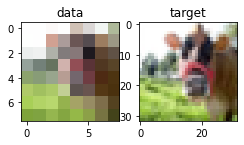

X Valid Image Shape: (8, 8, 3)
Y VaLid Image Shape: (32, 32, 3)
Test Image


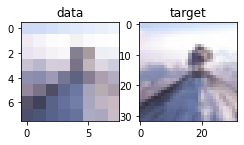

X Test Image Shape: (8, 8, 3)
Y Test Image Shape: (32, 32, 3)


In [14]:
# Unpickle Data
path = "./cifar-data/"
train_file_path = path + "train_32_16_4_8.dat"
valid_file_path = path + "valid_32_16_4_8.dat"
test_file_path = path + "test_32_16_4_8.dat"
x_train, y_train = unpack_pickle(train_file_path)
x_valid, y_valid = unpack_pickle(valid_file_path)
x_test, y_test = unpack_pickle(test_file_path)

# # downsize number of images
# x_train, y_train = x_train[:10], y_train[:10]
# x_valid, y_valid = x_valid[:10], y_valid[:10]
# x_test, y_test = x_test[:10], y_test[:10]


print("Train Image")
see_images([x_train[0], y_train[0]], ["data", "target"])
x_image_shape = x_train[0].shape
y_image_shape = y_train[0].shape
print("X Train Image Shape:", x_image_shape)
print("Y Train Image Shape:", y_image_shape)

print("Valid Image")
see_images([x_valid[0], y_valid[0]], ["data", "target"])
x_image_shape = x_valid[0].shape
y_image_shape = y_train[0].shape
print("X Valid Image Shape:", x_image_shape)
print("Y VaLid Image Shape:", y_image_shape)


print("Test Image")
see_images([x_test[0], y_test[0]],["data", "target"])
x_image_shape = x_test[0].shape
y_image_shape = y_test[0].shape
print("X Test Image Shape:", x_image_shape)
print("Y Test Image Shape:", y_image_shape)






In [15]:
# Need to resize the numpy array, since Conv2D expects (number, rgb channels, x, y)

def prepare_data_for_dataset(x, y):
    x = np.stack( x, axis=0)
    x = x.swapaxes(1, 3)
    y = np.stack( y, axis=0)
    y = y.swapaxes(1, 3)
    return x, y

x_train, y_train = prepare_data_for_dataset(x_train, y_train)
print("x_train new dimensions:", x_train.shape)
print("y_train new dimensions:", y_train.shape)

x_valid, y_valid = prepare_data_for_dataset(x_valid, y_valid)
print("x_valid new dimensions:", x_valid.shape)
print("y_valid new dimensions:", y_valid.shape)

x_test, y_test = prepare_data_for_dataset(x_test, y_test)
print("x_test new dimensions:", x_valid.shape)
print("y_test new dimensions:", y_valid.shape)

x_train new dimensions: (45000, 3, 8, 8)
y_train new dimensions: (45000, 3, 32, 32)
x_valid new dimensions: (5000, 3, 8, 8)
y_valid new dimensions: (5000, 3, 32, 32)
x_test new dimensions: (5000, 3, 8, 8)
y_test new dimensions: (5000, 3, 32, 32)


In [16]:
# Need to take images and place into dataset for easier use of data loader
class CompressionDataset(Dataset):
    def __init__(self, compressed_images, original_images, transforms=None) -> None:
        
        # scale input from 0 to 1
        self.original = original_images/255
        self.compressed = compressed_images/255
        
        
        if transforms != None: 
            for transform in transforms:
                self.original = transform(self.original)
                self.compressed = transform(self.compressed)
        super().__init__()
    def __len__(self):
        return len(self.original)
    def __getitem__(self, index):
        original_image = self.original[index]
        compressed_image = self.compressed[index]
        sample = {"Compressed":compressed_image, "Original":original_image}
        return sample


def ToTensor(array):
    return torch.from_numpy(array).float()


In [21]:

# Convert each set of images to a dataset

train_data_set = CompressionDataset(x_train, y_train, transforms= [ToTensor])
valid_data_set = CompressionDataset(x_valid, y_valid, transforms=[ToTensor])
test_data_set = CompressionDataset(x_test, y_test, transforms=[ToTensor])
batch_size = 32

image = train_data_set.compressed[0]

print("Train Image", type(image[0][0][0]))

image = test_data_set.compressed[0]
print("Test Image", type(image[0][0][0]))

train_data_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=False)
valid_data_loader = DataLoader(valid_data_set, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data_set, batch_size=batch_size, shuffle=False)

#Testing Data Loader to see if it got our data correctly
for (idx, batch) in enumerate(train_data_loader):
    print(batch["Compressed"][0][0][0][0], batch["Compressed"][0].max())
    # print(batch["Compressed"][0].swapaxes(0, 2).detach().numpy().shape)
    see_images(batch["Compressed"][0].swapaxes(0, 2), batch["Original"][0].swapaxes(0, 2))
    break # We just want first image in batch

for (idx, batch) in enumerate(test_data_loader):
    print("test",batch["Compressed"][0][0][0][0])
    see_images(batch["Compressed"][0].swapaxes(0, 2), batch["Original"][0].swapaxes(0, 2))
    break # We just want first image in batch

Train Image <class 'torch.Tensor'>
Test Image <class 'torch.Tensor'>
tensor(0.3373) tensor(0.6971)


AttributeError: ignored

In [23]:
class Residual_Model(nn.Module):
    def __init__(self) -> None:
        super(Residual_Model, self).__init__()
        self.up_2x = nn.Upsample(scale_factor = 2, mode='nearest')

        # do a convtranspose2d????
        self.conv1 = nn.Conv2d(3, 16, 2, padding = 'same')
        self.batchnorm1 = nn.BatchNorm2d(16)

        self.upconv1 =  nn.ConvTranspose2d(16, 64, 2, stride=2, padding=0)
        # concatenate upsampled
        self.batchnorm2 = nn.BatchNorm2d(64 + 3)

        self.conv2 = nn.Conv2d(64 + 3, 128, 2, padding = 'same')
        self.batchnorm3 = nn.BatchNorm2d(128)

        self.upconv2 = nn.ConvTranspose2d(128, 32, 2, stride=2, padding=0)
        # concatenate upsampled
        self.batchnorm4 = nn.BatchNorm2d(32 + 3)

        self.conv3 = nn.Conv2d(32+3, 3, 2, padding = 'same')

        # self.batchnorm1 = nn.BatchNorm2d(40) 
        # self.batchnor
        m2 = nn.BatchNorm2d(3)

# https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11#:~:text=Transposed%20convolutions%20are%20standard%20convolutions,in%20a%20standard%20convolution%20operation.
    def forward(self, x):
        # convolve 
        input = x.detach()
        x = self.batchnorm1(func.relu(self.conv1(x)))

        # upconv and concatenate upsampled 
        # print(torch.cat((self.up_2x(input), self.upconv1(x)), dim=1).shape)
        x = torch.cat((self.up_2x(input), self.upconv1(x)), dim=1)
        x = self.batchnorm2(func.relu(x))

        # convolve
        x = self.batchnorm3(func.relu(self.conv2(x)))

        # up conv and concatenate upsampled
        x = torch.cat((self.up_2x(self.up_2x(input)), self.upconv2(x)), dim=1)
        # x = self.batchnorm4(func.relu(x))
        return self.conv3(x)

# Test to see if it was working! 
for (idx, batch) in enumerate(train_data_loader):
    in_image = batch["Compressed"]
    test_net = Residual_Model()
    test_image = test_net.forward(in_image)
    # print(test_image)
    break


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


In [24]:
img = batch["Compressed"][0]#.swapaxes(0, 2)
img = torch.reshape(img, (1, 3, 8, 8))
print(img.shape)
up = nn.Upsample(scale_factor = 2, mode='nearest')


torch.Size([1, 3, 8, 8])


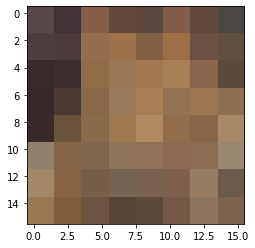

In [25]:
plt.imshow(torch.reshape(up(img), (3, 16, 16)).swapaxes(0,2))

In [26]:
from torchsummary import summary

vgg = Residual_Model()
summary(vgg, (3, 8, 8))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 8, 8]             208
       BatchNorm2d-2             [-1, 16, 8, 8]              32
          Upsample-3            [-1, 3, 16, 16]               0
   ConvTranspose2d-4           [-1, 64, 16, 16]           4,160
       BatchNorm2d-5           [-1, 67, 16, 16]             134
            Conv2d-6          [-1, 128, 16, 16]          34,432
       BatchNorm2d-7          [-1, 128, 16, 16]             256
          Upsample-8            [-1, 3, 16, 16]               0
          Upsample-9            [-1, 3, 32, 32]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          16,416
           Conv2d-11            [-1, 3, 32, 32]             423
Total params: 56,061
Trainable params: 56,061
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [27]:
# Ripped this part off of (will make a custom one later): https://nextjournal.com/gkoehler/pytorch-mnist
train_losses = []
train_counter = []
test_losses = []
n_epochs = 5
momentum = 0.5
learning_rate = 0.1
log_interval = 10
network = Residual_Model()
test_counter = [i*len(train_data_loader.dataset) for i in range(n_epochs + 1)]
optimizer = optim.Adam(network.parameters())



In [31]:


def train(epoch):
  network.train()
  for idx, batch in enumerate(train_data_loader):
    optimizer.zero_grad()
    output = network(batch["Compressed"])
    loss_func = nn.MSELoss()
    loss = loss_func(output, batch["Original"])
    loss.backward()
    optimizer.step()
    if idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, idx * len(batch["Compressed"]), len(train_data_loader.dataset),
        100. * idx / len(train_data_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (idx*64) + ((epoch-1)*len(train_data_loader.dataset)))
      # torch.save(network.state_dict(), './results/model.pth')
      # torch.save(optimizer.state_dict(), './results/optimizer.pth')

def test(): # Need to figure out how to evaluate based on loss
  network.eval()
  test_loss = 0
  correct = 0
  loss_func = nn.MSELoss(reduction = 'sum')
  with torch.no_grad():
    # for idx, batch in enumerate(test_data_loader):
    for idx, batch in enumerate(train_data_loader):

      output = network(batch["Compressed"])
      print("Loss:", loss_func(output,batch["Original"] ))
      for idx, image in enumerate(output):
        x = batch["Compressed"][idx].numpy().swapaxes(0, 2)
        y_hat = image.numpy().swapaxes(0, 2)
        y = batch["Original"][idx].numpy().swapaxes(0, 2)
        see_images([x, y_hat, y], ["x", "y_hat", "y"])
      break

Loss: tensor(0.3027)


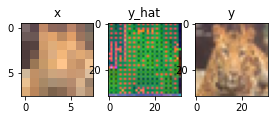

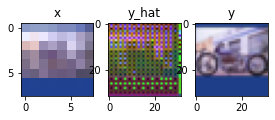

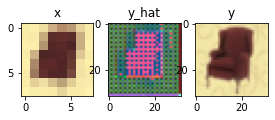

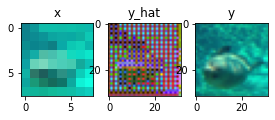

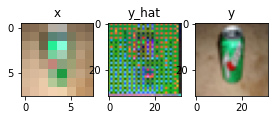

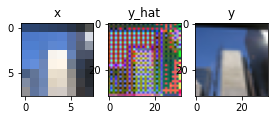

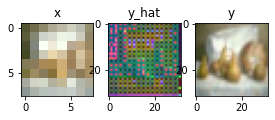

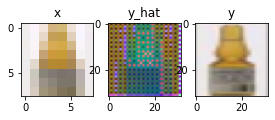

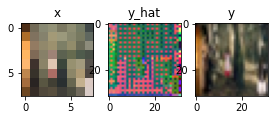

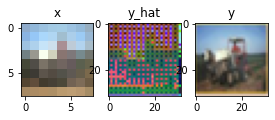

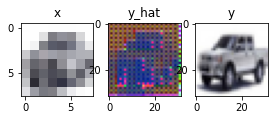

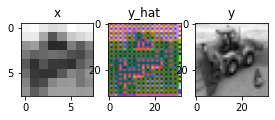

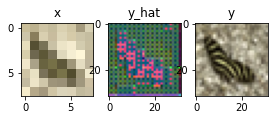

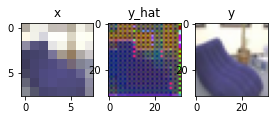

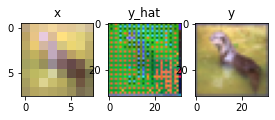

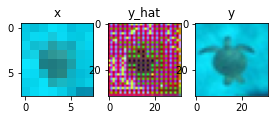

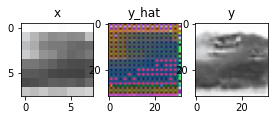

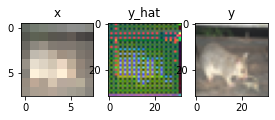

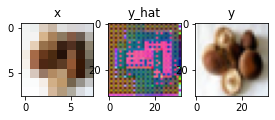

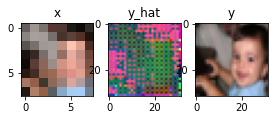

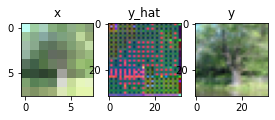

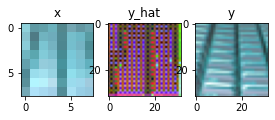

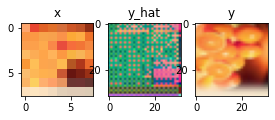

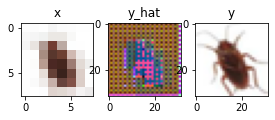

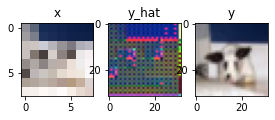

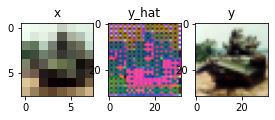

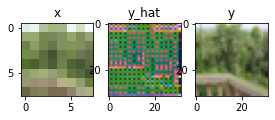

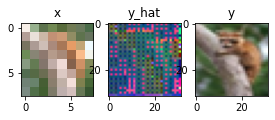

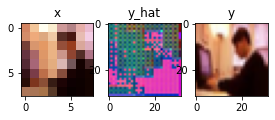

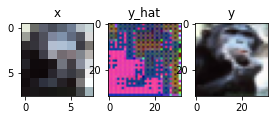

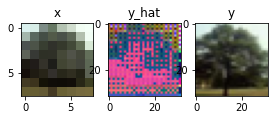

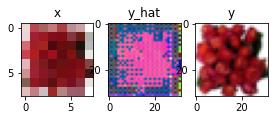

Train Epoch: 1 [0/45000 (0%)]	Loss: 0.404073
Train Epoch: 1 [320/45000 (1%)]	Loss: 0.149497
Train Epoch: 1 [640/45000 (1%)]	Loss: 0.073428
Train Epoch: 1 [960/45000 (2%)]	Loss: 0.021783
Train Epoch: 1 [1280/45000 (3%)]	Loss: 0.014639
Train Epoch: 1 [1600/45000 (4%)]	Loss: 0.014687
Train Epoch: 1 [1920/45000 (4%)]	Loss: 0.015837
Train Epoch: 1 [2240/45000 (5%)]	Loss: 0.013708
Train Epoch: 1 [2560/45000 (6%)]	Loss: 0.014630
Train Epoch: 1 [2880/45000 (6%)]	Loss: 0.011749
Train Epoch: 1 [3200/45000 (7%)]	Loss: 0.012086
Train Epoch: 1 [3520/45000 (8%)]	Loss: 0.010300
Train Epoch: 1 [3840/45000 (9%)]	Loss: 0.010779
Train Epoch: 1 [4160/45000 (9%)]	Loss: 0.010055
Train Epoch: 1 [4480/45000 (10%)]	Loss: 0.011364
Train Epoch: 1 [4800/45000 (11%)]	Loss: 0.012898
Train Epoch: 1 [5120/45000 (11%)]	Loss: 0.011464
Train Epoch: 1 [5440/45000 (12%)]	Loss: 0.009845
Train Epoch: 1 [5760/45000 (13%)]	Loss: 0.009851
Train Epoch: 1 [6080/45000 (14%)]	Loss: 0.013261
Train Epoch: 1 [6400/45000 (14%)]	Loss: 

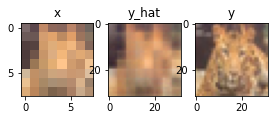

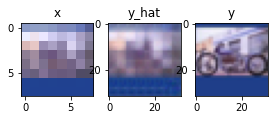

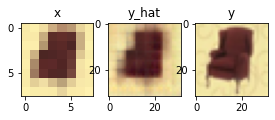

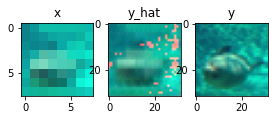

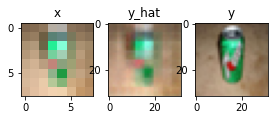

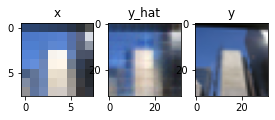

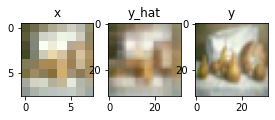

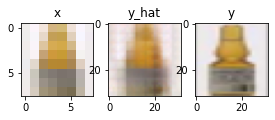

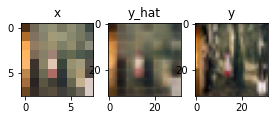

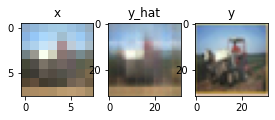

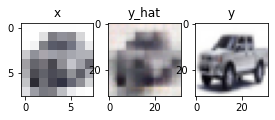

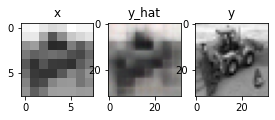

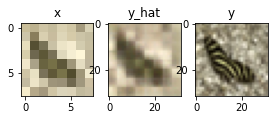

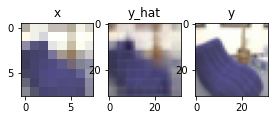

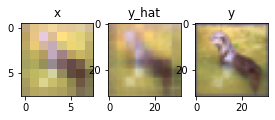

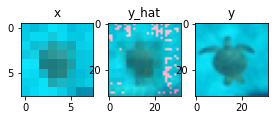

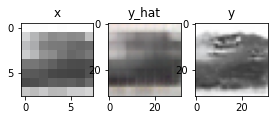

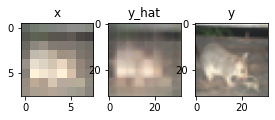

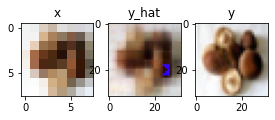

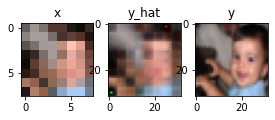

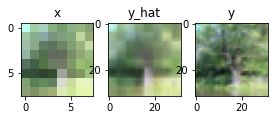

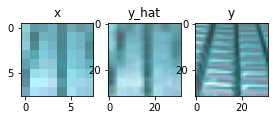

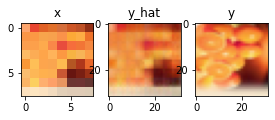

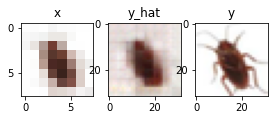

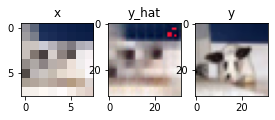

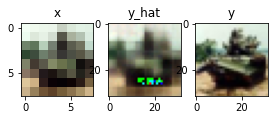

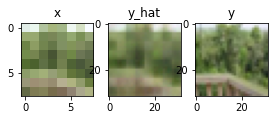

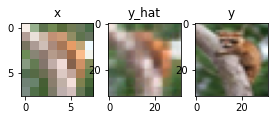

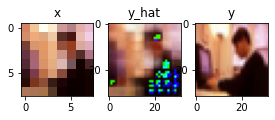

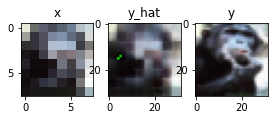

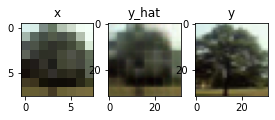

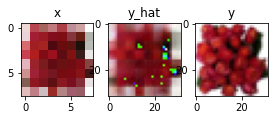

Train Epoch: 2 [0/45000 (0%)]	Loss: 0.010210
Train Epoch: 2 [320/45000 (1%)]	Loss: 0.009269
Train Epoch: 2 [640/45000 (1%)]	Loss: 0.008820
Train Epoch: 2 [960/45000 (2%)]	Loss: 0.011510
Train Epoch: 2 [1280/45000 (3%)]	Loss: 0.007900
Train Epoch: 2 [1600/45000 (4%)]	Loss: 0.008509
Train Epoch: 2 [1920/45000 (4%)]	Loss: 0.010008
Train Epoch: 2 [2240/45000 (5%)]	Loss: 0.010288
Train Epoch: 2 [2560/45000 (6%)]	Loss: 0.011145
Train Epoch: 2 [2880/45000 (6%)]	Loss: 0.009655
Train Epoch: 2 [3200/45000 (7%)]	Loss: 0.008796
Train Epoch: 2 [3520/45000 (8%)]	Loss: 0.007932
Train Epoch: 2 [3840/45000 (9%)]	Loss: 0.009141
Train Epoch: 2 [4160/45000 (9%)]	Loss: 0.007943
Train Epoch: 2 [4480/45000 (10%)]	Loss: 0.009495
Train Epoch: 2 [4800/45000 (11%)]	Loss: 0.010509
Train Epoch: 2 [5120/45000 (11%)]	Loss: 0.010145
Train Epoch: 2 [5440/45000 (12%)]	Loss: 0.008557
Train Epoch: 2 [5760/45000 (13%)]	Loss: 0.008787
Train Epoch: 2 [6080/45000 (14%)]	Loss: 0.011171
Train Epoch: 2 [6400/45000 (14%)]	Loss: 

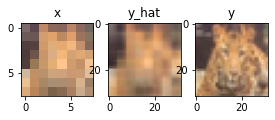

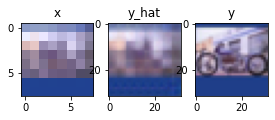

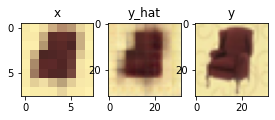

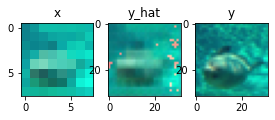

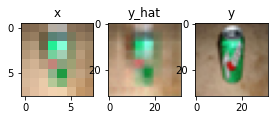

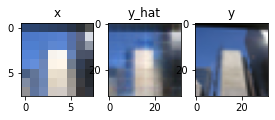

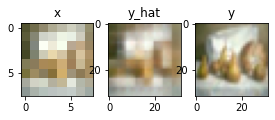

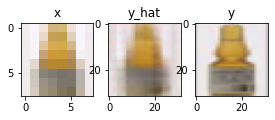

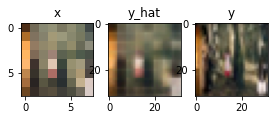

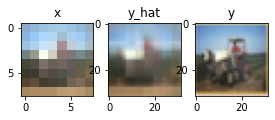

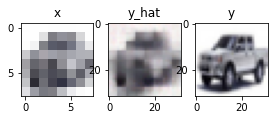

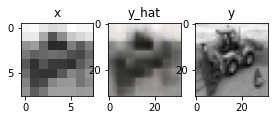

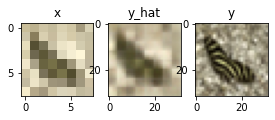

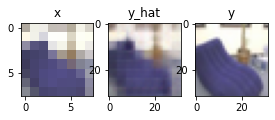

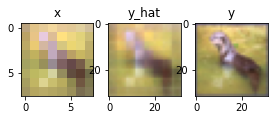

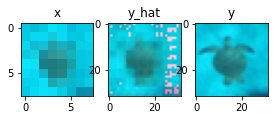

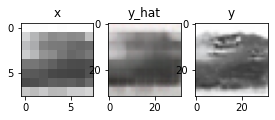

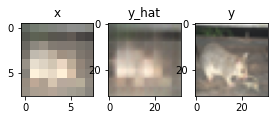

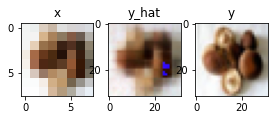

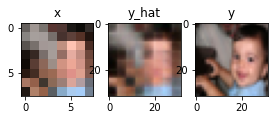

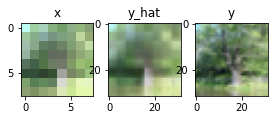

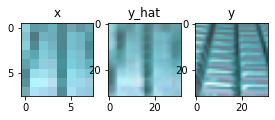

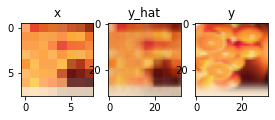

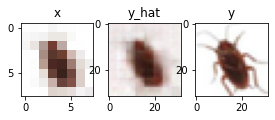

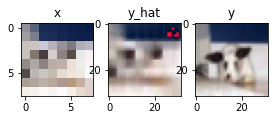

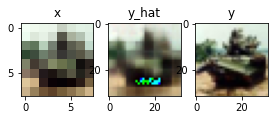

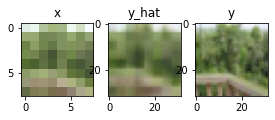

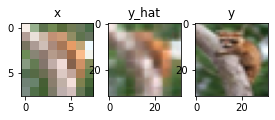

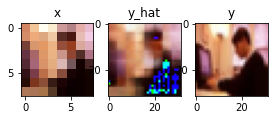

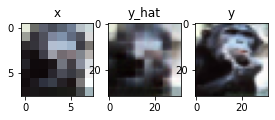

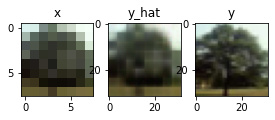

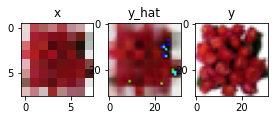

Train Epoch: 3 [0/45000 (0%)]	Loss: 0.009673
Train Epoch: 3 [320/45000 (1%)]	Loss: 0.009020
Train Epoch: 3 [640/45000 (1%)]	Loss: 0.008477
Train Epoch: 3 [960/45000 (2%)]	Loss: 0.011195
Train Epoch: 3 [1280/45000 (3%)]	Loss: 0.007706
Train Epoch: 3 [1600/45000 (4%)]	Loss: 0.008309
Train Epoch: 3 [1920/45000 (4%)]	Loss: 0.009739
Train Epoch: 3 [2240/45000 (5%)]	Loss: 0.009894
Train Epoch: 3 [2560/45000 (6%)]	Loss: 0.010569
Train Epoch: 3 [2880/45000 (6%)]	Loss: 0.009492
Train Epoch: 3 [3200/45000 (7%)]	Loss: 0.008482
Train Epoch: 3 [3520/45000 (8%)]	Loss: 0.007818
Train Epoch: 3 [3840/45000 (9%)]	Loss: 0.008977
Train Epoch: 3 [4160/45000 (9%)]	Loss: 0.007491
Train Epoch: 3 [4480/45000 (10%)]	Loss: 0.008951
Train Epoch: 3 [4800/45000 (11%)]	Loss: 0.009729
Train Epoch: 3 [5120/45000 (11%)]	Loss: 0.009797
Train Epoch: 3 [5440/45000 (12%)]	Loss: 0.008166
Train Epoch: 3 [5760/45000 (13%)]	Loss: 0.008643
Train Epoch: 3 [6080/45000 (14%)]	Loss: 0.010823
Train Epoch: 3 [6400/45000 (14%)]	Loss: 

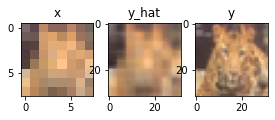

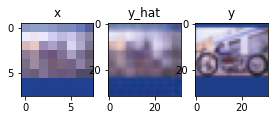

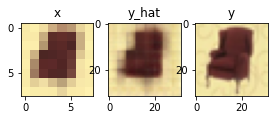

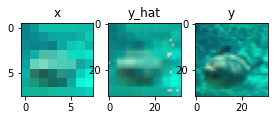

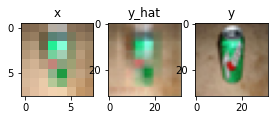

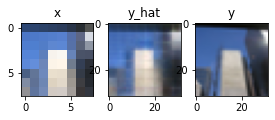

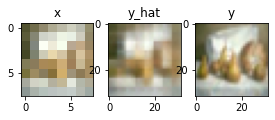

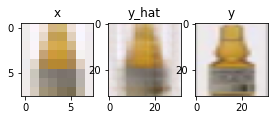

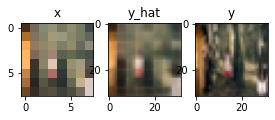

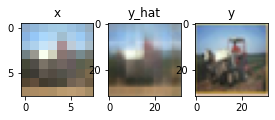

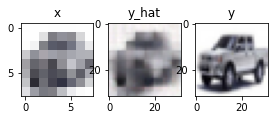

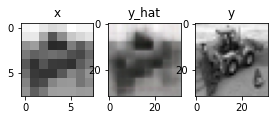

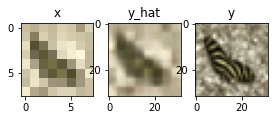

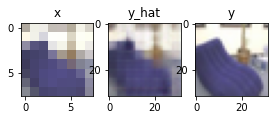

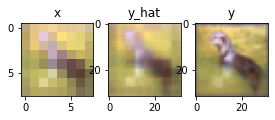

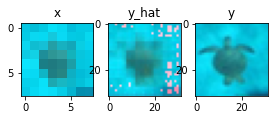

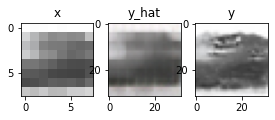

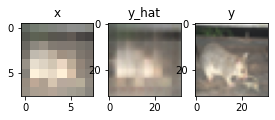

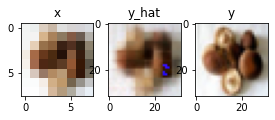

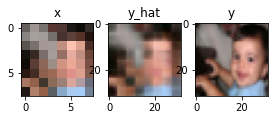

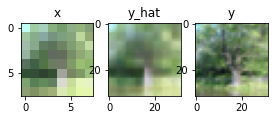

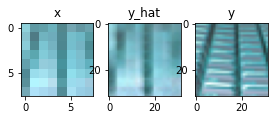

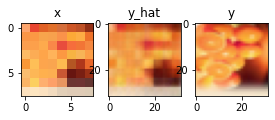

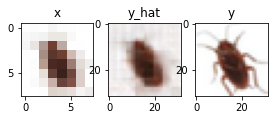

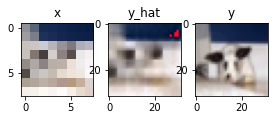

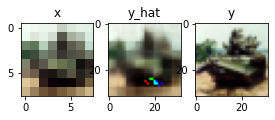

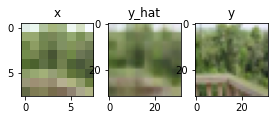

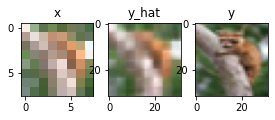

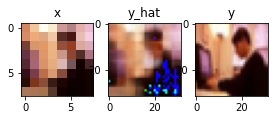

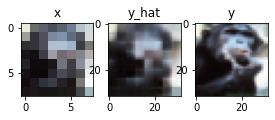

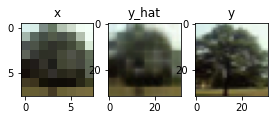

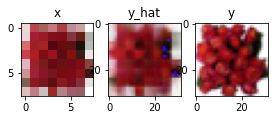

Train Epoch: 4 [0/45000 (0%)]	Loss: 0.009401
Train Epoch: 4 [320/45000 (1%)]	Loss: 0.008772
Train Epoch: 4 [640/45000 (1%)]	Loss: 0.008314
Train Epoch: 4 [960/45000 (2%)]	Loss: 0.011073
Train Epoch: 4 [1280/45000 (3%)]	Loss: 0.007529
Train Epoch: 4 [1600/45000 (4%)]	Loss: 0.008233
Train Epoch: 4 [1920/45000 (4%)]	Loss: 0.009577
Train Epoch: 4 [2240/45000 (5%)]	Loss: 0.009699
Train Epoch: 4 [2560/45000 (6%)]	Loss: 0.010301
Train Epoch: 4 [2880/45000 (6%)]	Loss: 0.009428
Train Epoch: 4 [3200/45000 (7%)]	Loss: 0.008359
Train Epoch: 4 [3520/45000 (8%)]	Loss: 0.007771
Train Epoch: 4 [3840/45000 (9%)]	Loss: 0.008883
Train Epoch: 4 [4160/45000 (9%)]	Loss: 0.007240
Train Epoch: 4 [4480/45000 (10%)]	Loss: 0.008752
Train Epoch: 4 [4800/45000 (11%)]	Loss: 0.009376
Train Epoch: 4 [5120/45000 (11%)]	Loss: 0.009582
Train Epoch: 4 [5440/45000 (12%)]	Loss: 0.007965
Train Epoch: 4 [5760/45000 (13%)]	Loss: 0.008483
Train Epoch: 4 [6080/45000 (14%)]	Loss: 0.010573
Train Epoch: 4 [6400/45000 (14%)]	Loss: 

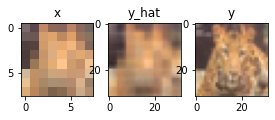

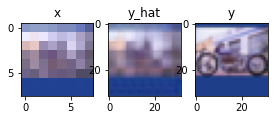

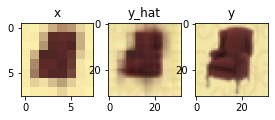

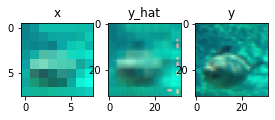

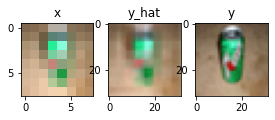

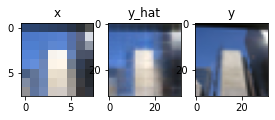

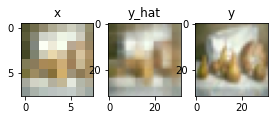

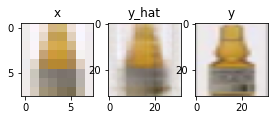

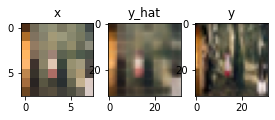

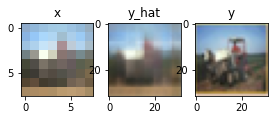

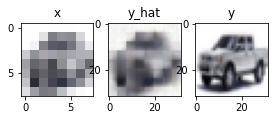

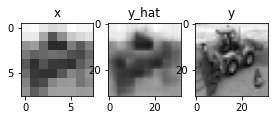

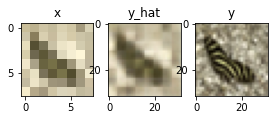

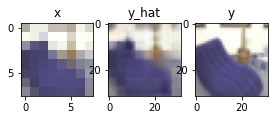

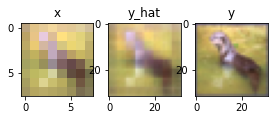

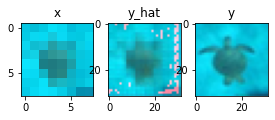

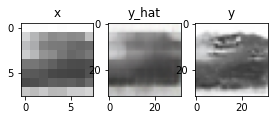

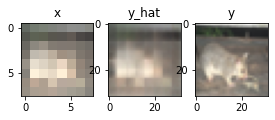

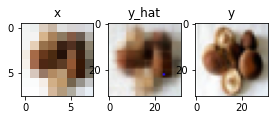

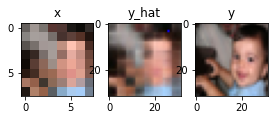

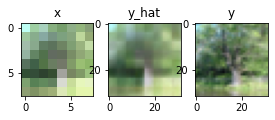

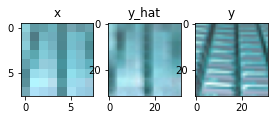

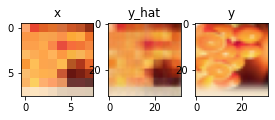

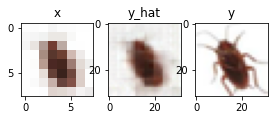

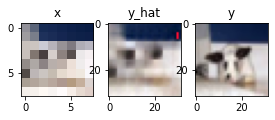

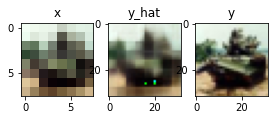

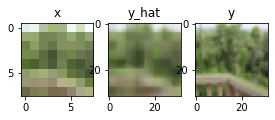

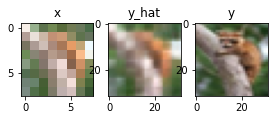

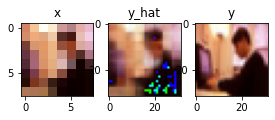

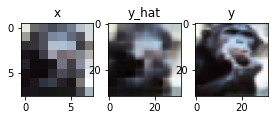

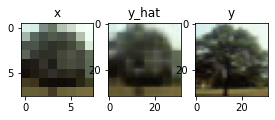

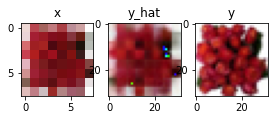

Train Epoch: 5 [0/45000 (0%)]	Loss: 0.009228
Train Epoch: 5 [320/45000 (1%)]	Loss: 0.008629
Train Epoch: 5 [640/45000 (1%)]	Loss: 0.008248
Train Epoch: 5 [960/45000 (2%)]	Loss: 0.011019
Train Epoch: 5 [1280/45000 (3%)]	Loss: 0.007397
Train Epoch: 5 [1600/45000 (4%)]	Loss: 0.008192
Train Epoch: 5 [1920/45000 (4%)]	Loss: 0.009485
Train Epoch: 5 [2240/45000 (5%)]	Loss: 0.009566
Train Epoch: 5 [2560/45000 (6%)]	Loss: 0.010111
Train Epoch: 5 [2880/45000 (6%)]	Loss: 0.009380
Train Epoch: 5 [3200/45000 (7%)]	Loss: 0.008263
Train Epoch: 5 [3520/45000 (8%)]	Loss: 0.007742
Train Epoch: 5 [3840/45000 (9%)]	Loss: 0.008839
Train Epoch: 5 [4160/45000 (9%)]	Loss: 0.007092
Train Epoch: 5 [4480/45000 (10%)]	Loss: 0.008649
Train Epoch: 5 [4800/45000 (11%)]	Loss: 0.009195
Train Epoch: 5 [5120/45000 (11%)]	Loss: 0.009507
Train Epoch: 5 [5440/45000 (12%)]	Loss: 0.007852
Train Epoch: 5 [5760/45000 (13%)]	Loss: 0.008396
Train Epoch: 5 [6080/45000 (14%)]	Loss: 0.010402
Train Epoch: 5 [6400/45000 (14%)]	Loss: 

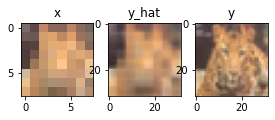

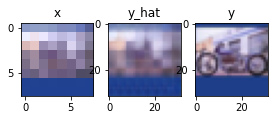

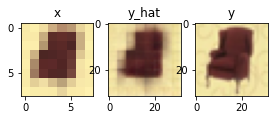

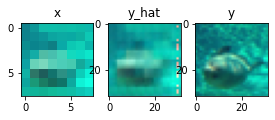

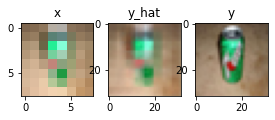

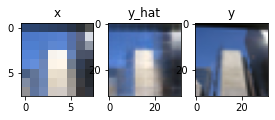

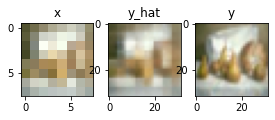

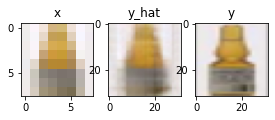

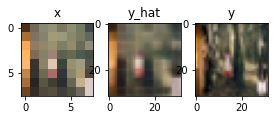

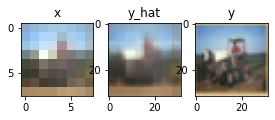

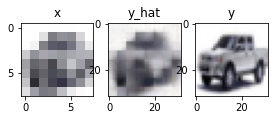

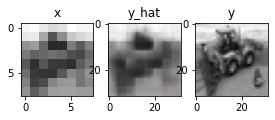

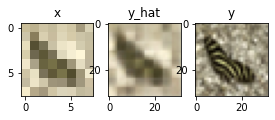

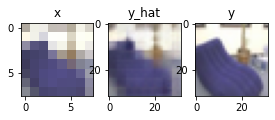

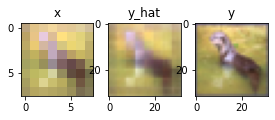

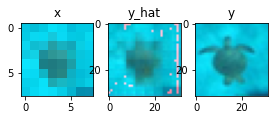

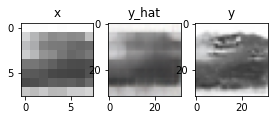

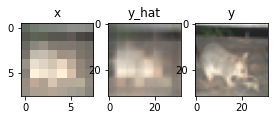

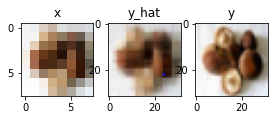

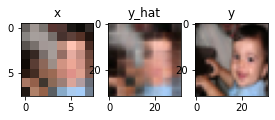

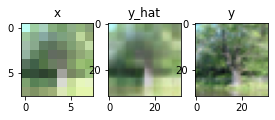

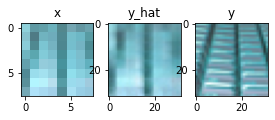

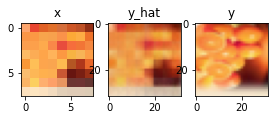

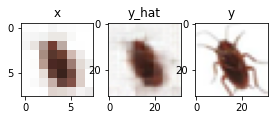

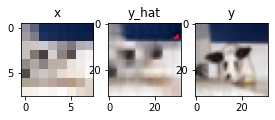

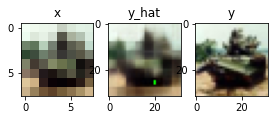

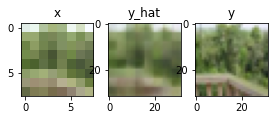

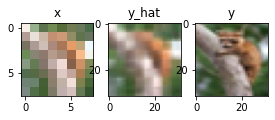

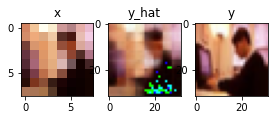

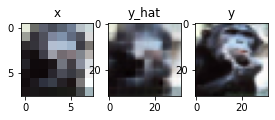

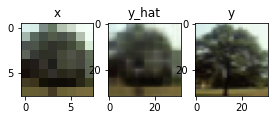

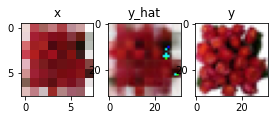

In [29]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  
  test()
  # input() # DELETE THIS TO CONTINUE TRAINING!

Loss: tensor(897.4384)


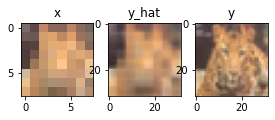

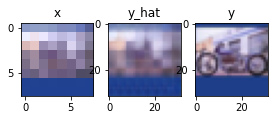

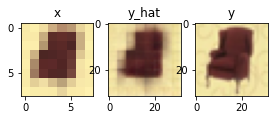

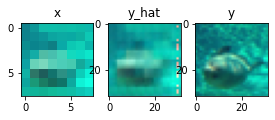

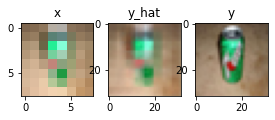

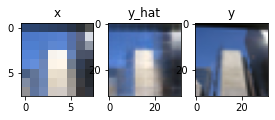

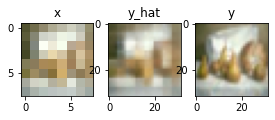

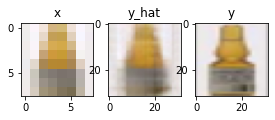

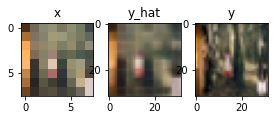

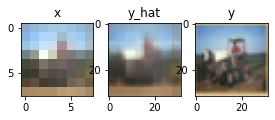

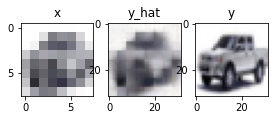

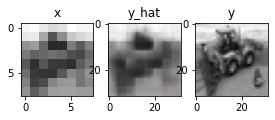

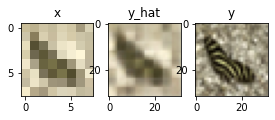

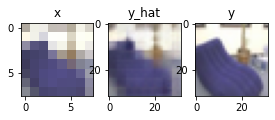

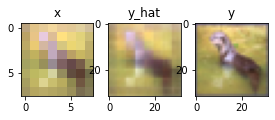

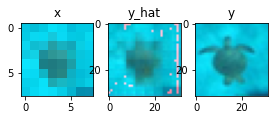

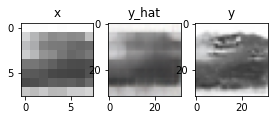

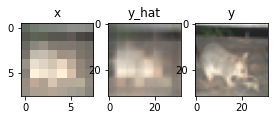

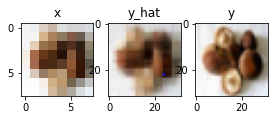

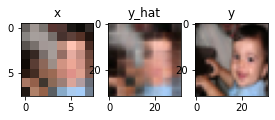

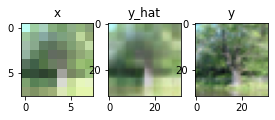

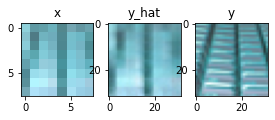

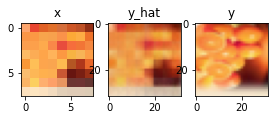

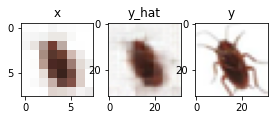

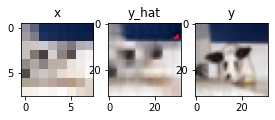

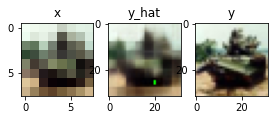

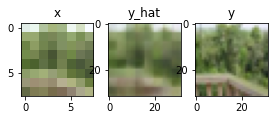

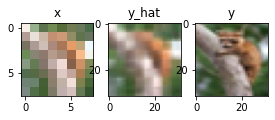

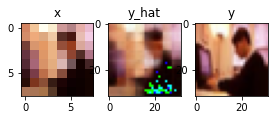

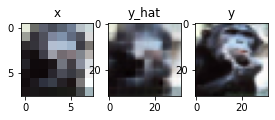

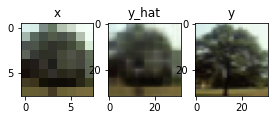

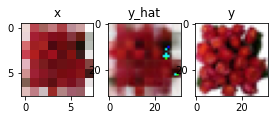

In [32]:
test()

In [33]:
torch.save(network.state_dict(), "./residual_model")

In [ ]:
os.getcwd()

'/content/drive/Shareddrives/ECE_792_Advanced_Topics_in_ML/compressed_images'

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-95-9cbe40f8f022>", line 1, in <module>
    from torchviz import make_dot
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 914, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1407, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1376, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1340, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback

OSError: ignored